In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [2]:
r = readers.CollectionReader('../src/clip_and_kl_experiment/agents')

100%|██████████| 160/160 [00:15<00:00, 10.31it/s]


In [3]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
#nadv = r.df('normalized_advantage')
#nadv['opt_step'] = (nadv.index % 50) * 10
#constraints = r.df('paper_constraints_train')
#constraints_heldout = r.df('paper_constraints_heldout')

In [4]:
games =  ["Walker2d-v2", "Humanoid-v2", "Swimmer-v2", "Hopper-v2",
          "HalfCheetah-v2", "InvertedPendulum-v2", "Reacher-v2", "InvertedDoublePendulum-v2"]
code_level_opts = {
      'kl_penalty_coeff': [0, 1, 3, 10],
      #'kl_penalty_direction': ['new_to_old', 'old_to_new'],
      #'clip_advantages': [1e8],
      #'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [5]:
#metadata['kl_penalty'] = (metadata['kl_penalty_coeff'] > 0)
#code_level_opts = {'kl_penalty': [True, False]}
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
#constraints = constraints.merge(key_metadata, on='exp_id')
#constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
#nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

# Plot mean rewards

In [ ]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    for i, cl_opt in enumerate(code_level_opts):
        for b in code_level_opts[cl_opt]:
            filt = opt[(opt[cl_opt] == b) & (opt.game == g)]
            sns.lineplot(filt.opt_step, filt.mean_reward,
                         ax=ax.flatten()[j], label=f"{cl_opt}: {b}", legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Reward')
ax[1][0].set_xlabel('Mean Reward')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

plt.show()

# Plot cumulative distribution of max rewards

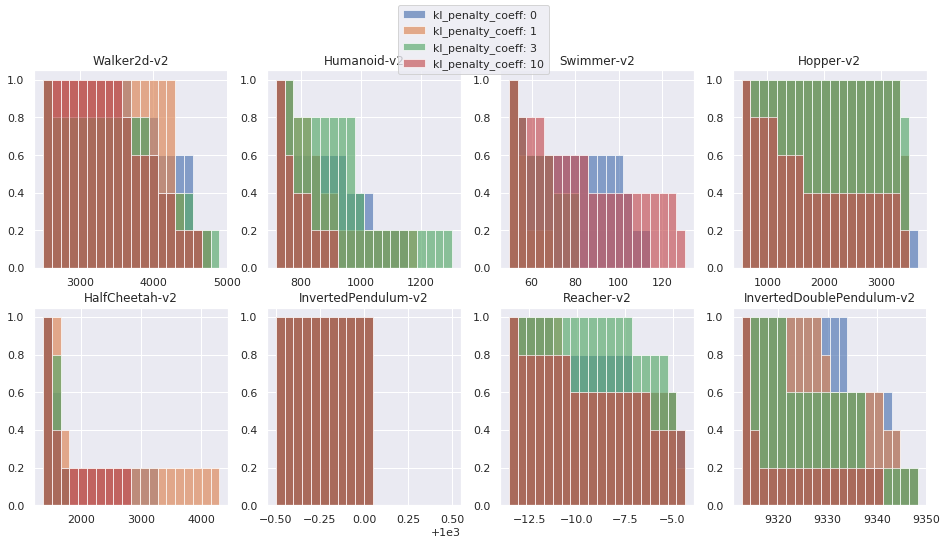

In [6]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            ax.flatten()[j].bar(bin_locs, hist, label=f"{cl_opt}: {b}",
                                **kwargs)
        ax.flatten()[j].set_title(g)
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Plot distribution of max rewards

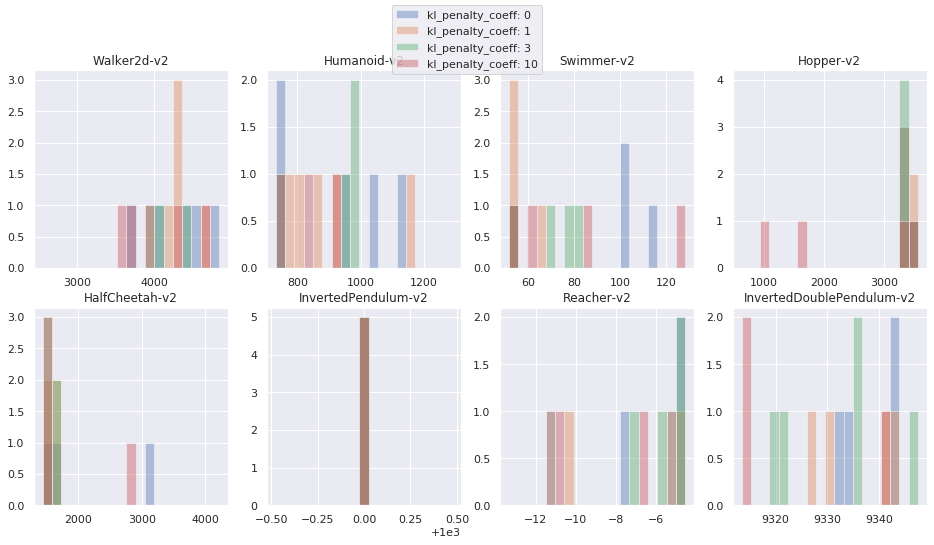

In [7]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            #hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            #hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            sns.distplot(filt['mean_reward'].tolist(),
                         bins=bin_locs, label=f"{cl_opt}: {b}", ax=ax.flatten()[j], kde=False)
        ax.flatten()[j].set_title(g)
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Aggregate performance in normalized scores

In [8]:
max_and_min = max_rewards[['game', 'mean_reward']].groupby('game').max().rename(
    columns={'mean_reward': 'max_max_reward'})
max_and_min['min_max_reward'] = max_rewards[['game', 'mean_reward']].groupby('game').min()

In [9]:
ks = ['game'] + list(code_level_opts.keys())
grouped = max_rewards[ks + ['mean_reward']].groupby(ks).mean().reset_index().set_index(ks)
grouped = grouped.rename(columns={'mean_reward': 'mean_max_reward'})
grouped['stddev'] = max_rewards[ks + ['mean_reward']].groupby(ks).var().reset_index().set_index(ks).apply(np.sqrt)
grouped = grouped.reset_index()
grouped = grouped.reset_index().merge(max_and_min, on='game')
grouped = grouped.set_index(ks)
grouped['normalized_score'] = (grouped['mean_max_reward'] - grouped['min_max_reward']) / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped['normalized_stddev'] = grouped['stddev'] / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped = grouped.dropna()
grouped

index  mean_max_reward  \
game                      kl_penalty_coeff                           
HalfCheetah-v2            0                     0      1820.471404   
                          1                     1      2140.154402   
                          3                     2      1584.654703   
                          10                    3      1745.641536   
Hopper-v2                 0                     4      3408.066930   
                          1                     5      3376.724079   
                          3                     6      3371.370633   
                          10                    7      1994.776141   
Humanoid-v2               0                     8       927.130120   
                          1                     9       901.603582   
                          3                    10       995.417025   
                          10                   11       784.945316   
InvertedDoublePendulum-v2 0                    12      9340.088556   
                          1                    13      9338.157457   
                          3                    14      9332.153180   
                          10                   15      9319.042158   
Reacher-v2                0                    20        -6.668452   
                          1                    21        -7.218076   
                          3                    22        -5.347166   
                          10                   23        -7.945566   
Swimmer-v2                0                    24        84.538936   
                          1                    25        55.180798   
                          3                    26        67.043626   
                          10                   27        91.385406   
Walker2d-v2               0                    28      4284.669416   
                          1                    29      4359.426513   
                          3                    30      3955.161713   
                          10                   31      4006.576461   

                                                 stddev  max_max_reward  \
game                      kl_penalty_coeff                                
HalfCheetah-v2            0                  753.557454     4295.895415   
                          1                 1207.187042     4295.895415   
                          3                   75.520732     4295.895415   
                          10                 575.549909     4295.895415   
Hopper-v2                 0                  138.738586     3642.937806   
                          1                   70.235813     3642.937806   
                          3                   49.276893     3642.937806   
                          10                1319.013483     3642.937806   
Humanoid-v2               0                  170.427243     1303.866541   
                          1                  155.938393     1303.866541   
                          3                  199.044336     1303.866541   
                          10                  82.887250     1303.866541   
InvertedDoublePendulum-v2 0                    6.725614     9348.385747   
                          1                    8.839612     9348.385747   
                          3                   11.476560     9348.385747   
                          10                  11.969602     9348.385747   
Reacher-v2                0                    2.823173       -4.344240   
                          1                    3.334778       -4.344240   
                          3                    1.097580       -4.344240   
                          10                   4.052521       -4.344240   
Swimmer-v2                0                   29.469035      130.495188   
                          1                    6.001868      130.495188   
                          3                   14.321424      130.495188   
                          10                  35.877297      130.495

In [11]:
ks = ['game'] + list(code_level_opts.keys())
tmp = max_rewards[ks + ['mean_reward']].merge(max_and_min, on='game')
tmp['normalized_score'] = (tmp['mean_reward'] - tmp['min_max_reward']) / (
    tmp['max_max_reward'] - tmp['min_max_reward'])
normalized_score = tmp[['game', 'kl_penalty_coeff', 'normalized_score']]
normalized_score['game'] = normalized_score['game'].apply(lambda s: s.strip('-v2'))

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


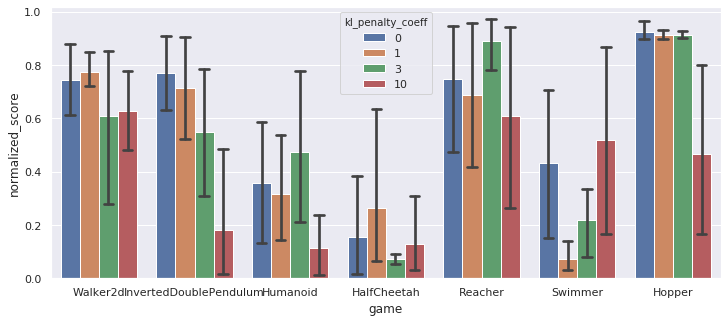

In [12]:
plt.figure(figsize=(12, 5))
sns.barplot(x="game", y="normalized_score", hue="kl_penalty_coeff",
            data=normalized_score.dropna().reset_index(), capsize=.1)

In [14]:
normalized_score.groupby('kl_penalty_coeff').describe()

normalized_score                                          \
                            count      mean       std       min       25%   
kl_penalty_coeff                                                            
0                            35.0  0.589837  0.346915  0.000000  0.310016   
1                            35.0  0.534283  0.374238  0.023468  0.140413   
3                            35.0  0.531682  0.367287  0.000000  0.161816   
10                           35.0  0.378166  0.371170  0.000000  0.038405   

                                           
                       50%       75%  max  
kl_penalty_coeff                           
0                 0.661817  0.893175  1.0  
1                 0.700643  0.903471  1.0  
3                 0.579839  0.904849  1.0  
10                0.312011  0.749325  1.0